In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import generative as gen
import numpy as np
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from utils import NetworkOptimizer

In [3]:
res_parcellation = 0
consensus_mat = scipy.io.loadmat(
    "datasets/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]
euclidean_dis = squareform(pdist(coordinates, metric='euclidean'))

In [4]:
optimizer = NetworkOptimizer(
        coordinates=coordinates,
        empirical_network=connectivity,
        n_iterations=1000,
        random_seed=42
    )
    
# Define parameter ranges
param_ranges = {
    'alpha': (0.1, 2.0),
}

# Run optimization
results = optimizer.optimize(
    param_ranges=param_ranges,
    n_calls=20,
    n_parallel_samples=16,
    verbose=True
)

Running Bayesian optimization...


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
ERROR:tornado.general:SEND Error: Host unreachable


KeyboardInterrupt: 

In [ ]:

# Create parameter trajectories
n_iterations = 10_000
n_nodes = connectivity.shape[0]
alpha = np.linspace(1,1, n_iterations)
beta = np.linspace(0.1, 0.1, n_iterations)  # Linear increase
noise = np.linspace(0, 0, n_iterations)
penalty = np.linspace(0, 0, n_iterations)

# Run simulation
history = gen.simulate_network_evolution(
    coordinates=coordinates,
    n_iterations=n_iterations,
    distance_fn=gen.resistance_distance,
    alpha=alpha,
    beta=beta,
    noise=noise,
    connectivity_penalty=penalty,
    n_jobs=-1,  # Use all available cores
    random_seed=42,
    batch_size=16,
)

Simulating network evolution: 100%|██████████| 9999/9999 [04:55<00:00, 33.79it/s]


In [112]:
fit_vector = np.zeros(history.shape[2])
for t in tqdm(range(history.shape[2]), desc="Evaluating network evolution"):
    fit_vector[t] = fast_evaluator(history[:,:,t], connectivity, euclidean_dis)

Evaluating network evolution: 100%|██████████| 10000/10000 [14:24<00:00, 11.57it/s]


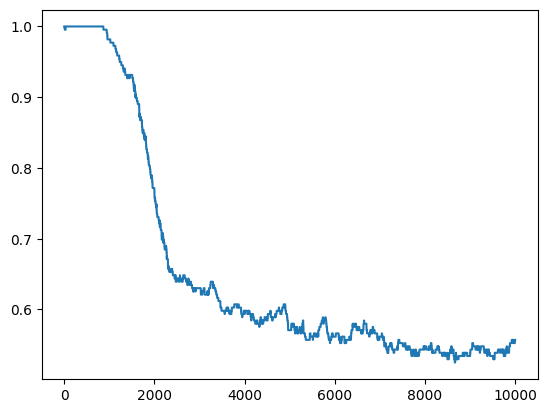

In [113]:
plt.plot(fit_vector)

In [114]:
fit_vector.min()

0.5251141552511416

In [116]:
bestfit = np.argmin(fit_vector)
bestfit

8658

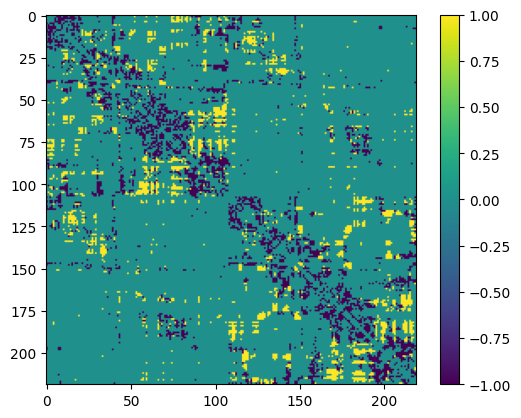

In [118]:
plt.imshow(connectivity-history[:,:,bestfit], aspect='equal',)
plt.colorbar()

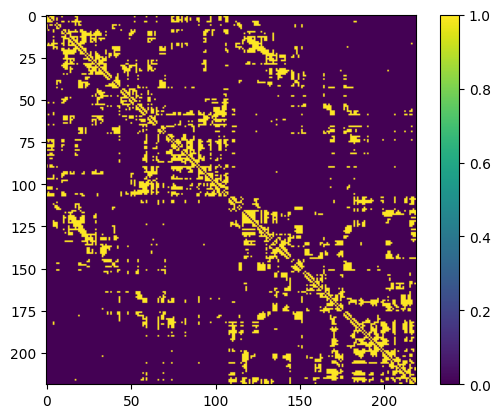

In [119]:
plt.imshow(connectivity, aspect='equal',)
plt.colorbar()